<a href="https://colab.research.google.com/github/1eetnals/coursera-tfcertificate/blob/main/C4_W2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


Downloading...
From: https://drive.google.com/uc?id=1sDzcLKVZBQWeEYT101bEWCltlaFPjiIN
To: /content/C4_W2_Assignment_Image.png
100% 18.5k/18.5k [00:00<00:00, 19.8MB/s]
Expected:


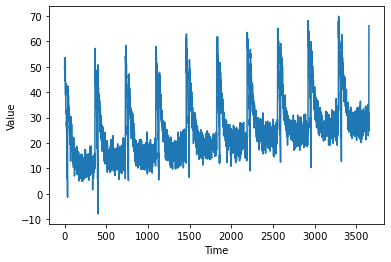

Your output:


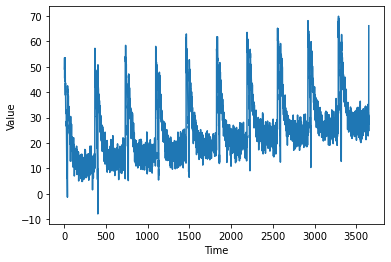

In [ ]:
# plot_series() 함수 : 임의의 시간 값(time), 시계열 데이터(series)를 입력받아 Matplotlib 그래프로 나타내는 함수
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")  # x축 label을 Time으로 지정
    plt.ylabel("Value")   # y축 label을 Value로 지정
    plt.grid(False)  # 그래프의 x,y축에 대해 그리드 표시 x

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), # YOUR CODE HERE # * np.pi),
                    2 / np.exp(9 * season_time)) #YOUR CODE HERE# / np.exp(#YOUR CODE HERE# * season_time))
# seasonal_pattern() 함수는 입력 season_time에 대해서 
# 0.1보다 작은 경우에는 np.cos(season_time*7*np.pi) 값을, <- np.cos는 cos값 반환
# 그렇지 않은 경우에는 1/np.exp(9*season_time)을 반환. <- np.exp()는 e^x 함수

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10 # YOUR CODE HERE #
series = trend(time, 0.1)# YOUR CODE HERE#)    
baseline = 10
amplitude = 40
slope = 0.005 # YOUR CODE HERE#
noise_level = 3 # YOUR CODE HERE#
# 노이즈를 얼마나 만들어 줄 것인가

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

# 시계열 데이터의 앞부분 3000개가 훈련용, 나머지는 검증용 데이터로 분리
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20  # 20개 데이터 요소를 가진 시퀀스 데이터로 설정
batch_size = 32   # 한 번 학습할 때 32개의 시퀀스를 한 배치로 학습
shuffle_buffer_size = 1000

# # # # # expected output
!gdown --id 1sDzcLKVZBQWeEYT101bEWCltlaFPjiIN
print("Expected:")
from IPython.display import display
from PIL import Image
path='./C4_W2_Assignment_Image.png'
display(Image.open(path))
# # # # #

### your output
print("Your output:")
plot_series(time, series)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  # window method를 이용해서 window size+1 만큼의 시퀀스 데이터 생성
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  # flat_map은 해당 데이터 세트를 펼쳐주는 것
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  # 효과적인 학습을 위해 해당 배치들을 섞음
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  # prefetch(1)은 배치를 미리 한 개 더 만들어놔서 빠르게 학습할 수 있는 옵션
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), # YOUR CODE HERE #),
    tf.keras.layers.Dense(10, activation="relu"), # YOUR CODE HERE #, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))# YOUR CODE HERE #, optimizer=# YOUR CODE HERE#))
model.fit(dataset,epochs=100,verbose=0)


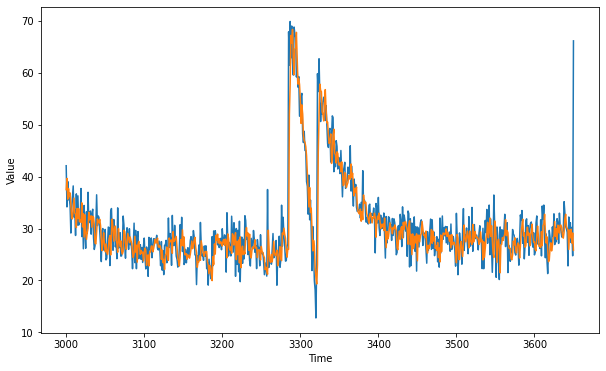

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))   # input shape을 맞춰주기 위해 new axis 사용

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
# MAE 값 출력
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

3.134831